# Cross cross resonance SWAP

## 1. Isolate the well maintained and calibrated Cross Resonance pulse 

- CR is implemented in standard CNOT gate: go and analyze those CNOT pulses to find and isolate CR!

- CR pulse is equivalent to Rxz(pi / 4)

- CR pulse drives control qubit with frequency of target qubit

- Maintained CR pulse only implementes for one direction for each qubit pair (backend uses a lot of extra pulses to rotate qubits back and forth before and after CR, if CNOT is used in the not implemented direction) -> maby two extra lines of code here to switch directions of standard SWAP instead of actually rotating qubits?


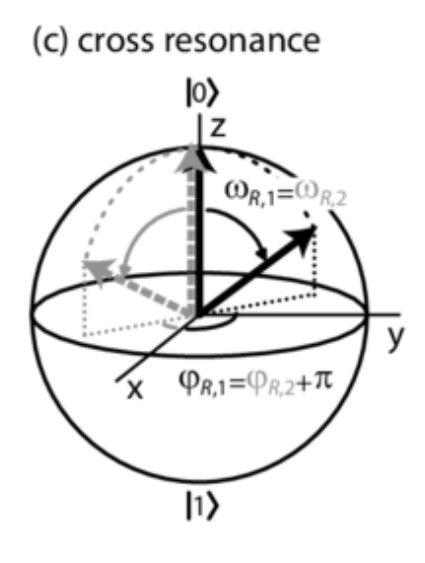


### CR Analysis

In [ ]:
from qiskit import pulse
import os, json
import numpy as np
import matplotlib.pyplot as plt
from qiskit.pulse import Play, Schedule, DriveChannel, ControlChannel, Waveform
from qiskit.pulse.library import drag, GaussianSquare
from qiskit.visualization import SchedStyle
from qiskit import QuantumCircuit, Aer, IBMQ
from qiskit.test.mock import FakeAthens
IBMQ.load_account()
style = SchedStyle(figsize=(20, 10))
plt.style.use('dark_background')
plt.rcParams['figure.figsize'] = [15, 15]
provider = IBMQ.get_provider(hub='ibm-q-community', group='ibmquantumawards', project='open-science')
backend = provider.get_backend('ibmq_casablanca')

In [ ]:
backend_config = backend.configuration()
ham_params = backend_config.hamiltonian['vars']
dt = backend_config.dt
print(f"Sampling time: {dt*1e9} ns\n\n") 
backend_defaults = backend.defaults()
inst_sched_map = backend_defaults.instruction_schedule_map 
print(inst_sched_map.instructions)
print("\t"*8," 'x' and 'measure' are pulses for echoes\n")
print("\t"*8," 'u1' ,'u2' and 'u3' are single qubit gates\n")
meas = inst_sched_map.get('measure', qubits=range(backend_config.n_qubits))
print('pulse for measure:')
meas.exclude(channels=[pulse.AcquireChannel(i) for i in range(backend_config.n_qubits)]).draw(style=style)

In [29]:
def cx_pulse_instructions(qc: int, qt: int) -> Schedule:
    if [qc, qt] not in backend_config.coupling_map:
        print('Qubit pair has no direct cross resonance!')
    else:
        cx = inst_sched_map.get('cx', qubits=[qc, qt])
        return cx
    
def get_cr_chan_inst(qc: int, qt: int) -> (ControlChannel, Waveform):
    cx = cx_pulse_instructions(qc, qt)
    idx = 0
    # look for first Play instruction on a ControlChannel
    while (type(cx.instructions[idx][1].channels[0]) is not ControlChannel) or \
        (type(cx.instructions[idx][1]) is not Play):
        idx += 1
    return (cx.instructions[idx][1].channels[0], cx.instructions[idx][1].pulse)

In [30]:
uchan_c1t3, cr_pulse_c1t3 = get_cr_chan_inst(1, 3)
params_CRpulse_c1t3 = cr_pulse_c1t3.parameters
CX_c1t3_intrusctions = cx_pulse_instructions(1, 3)
print("\ncr_pulse_c1t3: \n\t\t\t",cr_pulse_c1t3,"\nuchan_c1t3: \n\t\t\t", uchan_c1t3)
print("CR pulse parameters: \n\t\t\t", params_CRpulse_c1t3)

uchan_c3t1, cr_pulse_c3t1 = get_cr_chan_inst(3, 1)
params_CRpulse_c3t13 = cr_pulse_c3t1.parameters
CX_c3t1_intrusctions = cx_pulse_instructions(3, 1)
print("\n\ncr_pulse_c3t1: \n\t\t\t",cr_pulse_c3t1,"\nuchan_c3t1: \n\t\t\t",uchan_c3t1)
print("CR pulse parameters: \n\t\t\t", params_CRpulse_c3t13)

if [uchan_c1t3 == uchan_c3t1, cr_pulse_c1t3 == cr_pulse_c3t1, params_CRpulse_c1t3 == params_CRpulse_c3t13] == [True,True,True]:
    print("\n\nCR pulse, Channel and Parameters are the same for control 3 + target 1 and control 1 + target 3\n\n")
        
print('\n\nCX instructions for control 3 target 1: \n\t\t\t\t\t', CX_c3t1_intrusctions)
print('\n\nCX instructions for control 1 target 3: \n\t\t\t\t\t', CX_c1t3_intrusctions)


cr_pulse_c1t3: 
			 GaussianSquare(duration=560, amp=(-0.3284667505753208-0.1625741842209951j), sigma=64, width=304) 
uchan_c1t3: 
			 ControlChannel(5)
CR pulse parameters: 
			 {'duration': 560, 'amp': (-0.3284667505753208-0.1625741842209951j), 'sigma': 64, 'width': 304}


cr_pulse_c3t1: 
			 GaussianSquare(duration=560, amp=(-0.3284667505753208-0.1625741842209951j), sigma=64, width=304) 
uchan_c3t1: 
			 ControlChannel(5)
CR pulse parameters: 
			 {'duration': 560, 'amp': (-0.3284667505753208-0.1625741842209951j), 'sigma': 64, 'width': 304}


CR pulse, Channel and Parameters are the same for control 3 + target 1 and control 1 + target 3




CX instructions for control 3 target 1: 
					 Schedule((0, ShiftPhase(1.5707963267948966, DriveChannel(3))), (0, ShiftPhase(1.5707963267948966, ControlChannel(3))), (0, ShiftPhase(1.5707963267948966, ControlChannel(8))), (0, Play(Drag(duration=160, amp=(0.0911314424244252+0.0015627714756668424j), sigma=40, beta=-0.6633431548117166), DriveChanne

### Note: Implemented CR goes in direction control 3 -> target 1

- If control is defined as 1 and target as 3 there are a lot of extra rotation before and after CR pulse
- Implemented CR drives control 3 with frequency of target 1

In [45]:
print(cr_pulse_c3t1) # drive control 3 in frequency of target 1

GaussianSquare(duration=560, amp=(-0.3284667505753208-0.1625741842209951j), sigma=64, width=304)


In [31]:
CX_c3t1_intrusctions.timeslots

{DriveChannel(1): [(0, 160), (160, 720), (880, 1440)],
 DriveChannel(3): [(0, 0), (0, 160), (720, 880)],
 ControlChannel(3): [(0, 0)],
 ControlChannel(5): [(160, 720), (880, 1440)],
 ControlChannel(8): [(0, 0)]}

In [32]:
CX_c1t3_intrusctions.timeslots

{DriveChannel(1): [(0, 0),
  (0, 160),
  (160, 720),
  (880, 1440),
  (1440, 1440),
  (1440, 1600)],
 DriveChannel(3): [(0, 0), (0, 160), (720, 880), (1440, 1600)],
 ControlChannel(0): [(0, 0), (1440, 1440)],
 ControlChannel(3): [(0, 0)],
 ControlChannel(4): [(0, 0), (1440, 1440)],
 ControlChannel(5): [(0, 0), (160, 720), (880, 1440), (1440, 1440)],
 ControlChannel(8): [(0, 0)]}

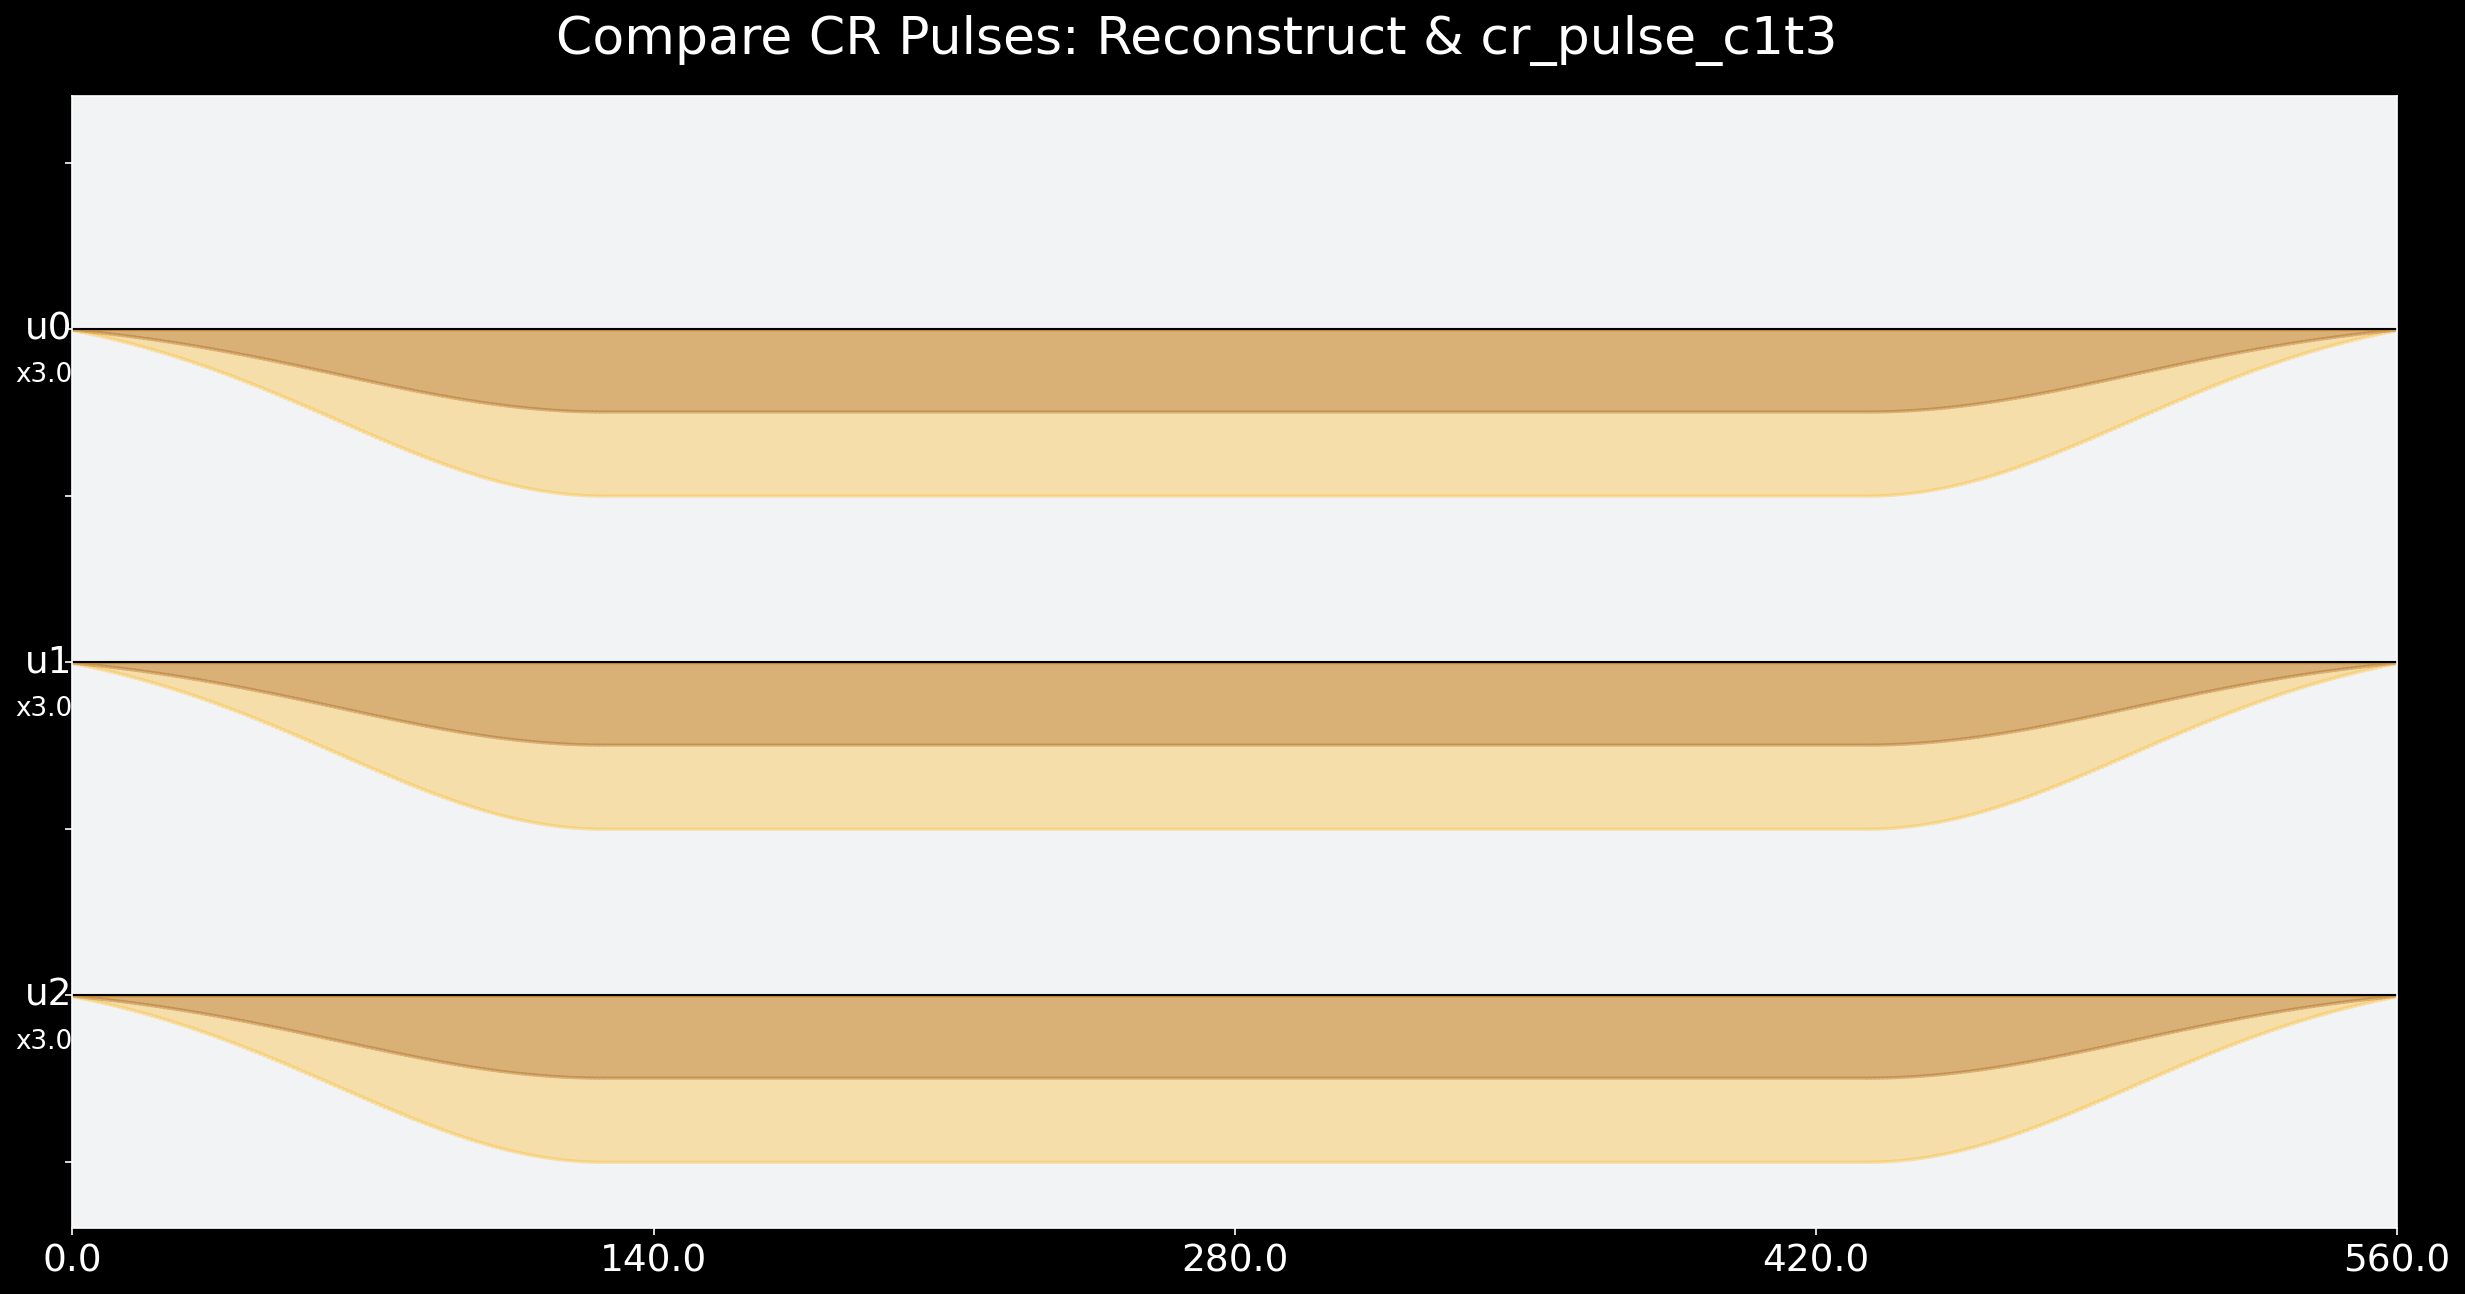

In [33]:
cr_risefall = 128 # guess

cr_amp_c1t3 = cr_pulse_c1t3.amp
cr_dur_c1t3 = cr_pulse_c1t3.duration
cr_width_c1t3 = cr_dur_c1t3 - 2*cr_risefall

cr_amp_c3t1 = cr_pulse_c3t1.amp
cr_dur_c3t1 = cr_pulse_c3t1.duration
cr_width_c3t1 = cr_dur_c3t1 - 2*cr_risefall

reconstructed_CR_pulse = GaussianSquare(duration=cr_dur_c1t3, amp=cr_amp_c1t3, sigma=cr_risefall//2, width=cr_width_c1t3)
reconstructed_CR_pulse.draw()

with pulse.build(name="Compare CR Pulses: Reconstruct & cr_pulse_c1t3") as cr_test_sched:
    pulse.play(cr_pulse_c1t3, ControlChannel(0))
    pulse.play(cr_pulse_c3t1, ControlChannel(1))
    pulse.play(reconstructed_CR_pulse, ControlChannel(2))

cr_test_sched.draw(style=style)

In [34]:
def build_cr_pulse(qc: int, qt: int, width: int, control='0', basis='Z', phase=0.0, framechange=0.0) -> Schedule:
    with pulse.build() as sched:
        with pulse.align_sequential():
            if control == '1':
                Xp = inst_sched_map.get('x', qubits=[qc])
                pulse.call(Xp) # flip control from |0> to |1>
            duration = width + 2*cr_risefall
            uchan, _ = get_cr_chan_inst(qc,qt)
            with pulse.phase_offset(phase, uchan):
                pulse.play(GaussianSquare(duration=duration, amp=cr_amp, sigma=cr_risefall//2, width=width), uchan)
            pulse.shift_phase(framechange, DriveChannel(qc))
            if basis == 'X': # rotate target for appropriate Pauli measurement
                Y90m = inst_sched_map.get('u2', P0=np.pi, P1=np.pi, qubits=[qt])
                pulse.call(Y90m)
            elif basis == 'Y':
                X90p = inst_sched_map.get('u2', P0=-np.pi/2, P1=np.pi/2, qubits=[qt])
                pulse.call(X90p) 
            return sched

def build_cr_scheds(qc: int, qt: int, cr_times, phase=0.0, ZI_MHz=0.0) -> np.array:
    scheds = []
    for width in cr_times:
        framechange = 2*np.pi*int(width)*dt*ZI_MHz*1e6
        for basis in ['X', 'Y', 'Z']:
            for control in ['0', '1']:
                with pulse.build(name="CR width %i" %width) as sched:
                    with pulse.align_sequential():
                        pulse.call(build_cr_pulse(qc, qt, int(width), control=control, \
                                                  basis=basis, phase=phase, framechange=framechange))
                        pulse.call(meas)
                scheds.append(sched)
    return scheds

In [36]:
backend_config = backend.configuration()
backend_defaults = backend.defaults()
dt=backend_config.dt  # hardware resolution
backend.configuration().parametric_pulses = [] # will allow us to send a larger waveform for our experiments

In [37]:
from scipy.optimize import leastsq,minimize, curve_fit

# samples need to be multiples of 16 to accommodate the hardware limitations
def get_closest_multiple_of_16(num):
    return int(num + 8 ) - (int(num + 8 ) % 16)

# lorentzian function
def lorentzian(f, f0, k, a, offs):
    return a*k/(2*np.pi)/((k/2)**2+(f-f0)**2)+offs

#fit_lorentzian takes two arrays that contain the frequencies and experimental output values of each frequency respectively. 
#returns the lorentzian parameters that best fits this output of the experiment.
#popt are the fit parameters and pcov is the covariance matrix for the fit
def fit_lorentzian(freqs,values):
    p0=[freqs[np.argmax(values)],(freqs[-1]-freqs[0])/2,max(values),0]
    bounds=([freqs[0],0,0,-np.inf],[freqs[-1],freqs[-1]-freqs[0],np.inf,np.inf])
    popt,pcov=curve_fit(lorentzian, freqs, values, p0=p0, bounds=bounds)
    return popt,pcov

# Gaussian function
def gaussian(f, f0, sigma, a, offs):
    return a*np.exp(-(f-f0)**2/(2*sigma**2))+offs

#fit_gaussian takes two arrays that contain the frequencies and experimental output values of each frequency respectively. 
#returns the gaussian parameters that best fits this output of the experiment.
#popt are the fit parameters and pcov is the covariance matrix for the fit
def fit_gaussian(freqs,values):
    p0=[freqs[np.argmax(values)],(freqs[-1]-freqs[0])/2,max(values),0]
    bounds=([freqs[0],0,0,-np.inf],[freqs[-1],freqs[-1]-freqs[0],np.inf,np.inf])
    popt,pcov=curve_fit(gaussian, freqs, values, p0=p0, bounds=bounds)
    return popt,pcov

# normalize the data points to fall in the range of [0,1]
def normalize(a):
    a= a-min(a)
    return a/max(a)

In [38]:
uchan_c1t3, cr_pulse_c1t3 = get_cr_chan_inst(1, 3)
params_CRpulse_c1t3 = cr_pulse_c1t3.parameters
CX_c1t3_intrusctions = cx_pulse_instructions(1, 3)

## Reconstruct CR pulse

In [39]:
drive_chan_Q3 = pulse.DriveChannel(3)   # drive channel
meas_chan_Q3 = pulse.MeasureChannel(3)  # resonator channel
acq_chan_Q3 = pulse.AcquireChannel(3)   # readout signal acquisition channel

drive_chan_Q1 = pulse.DriveChannel(1)   # drive channel
meas_chan_Q1 = pulse.MeasureChannel(1)  # resonator channel
acq_chan_Q1 = pulse.AcquireChannel(1)   # readout signal acquisition channel

default_duration=560
default_amp = (-0.32609606664029767-0.1591967745569052j)
default_sigma=64
default_width=304

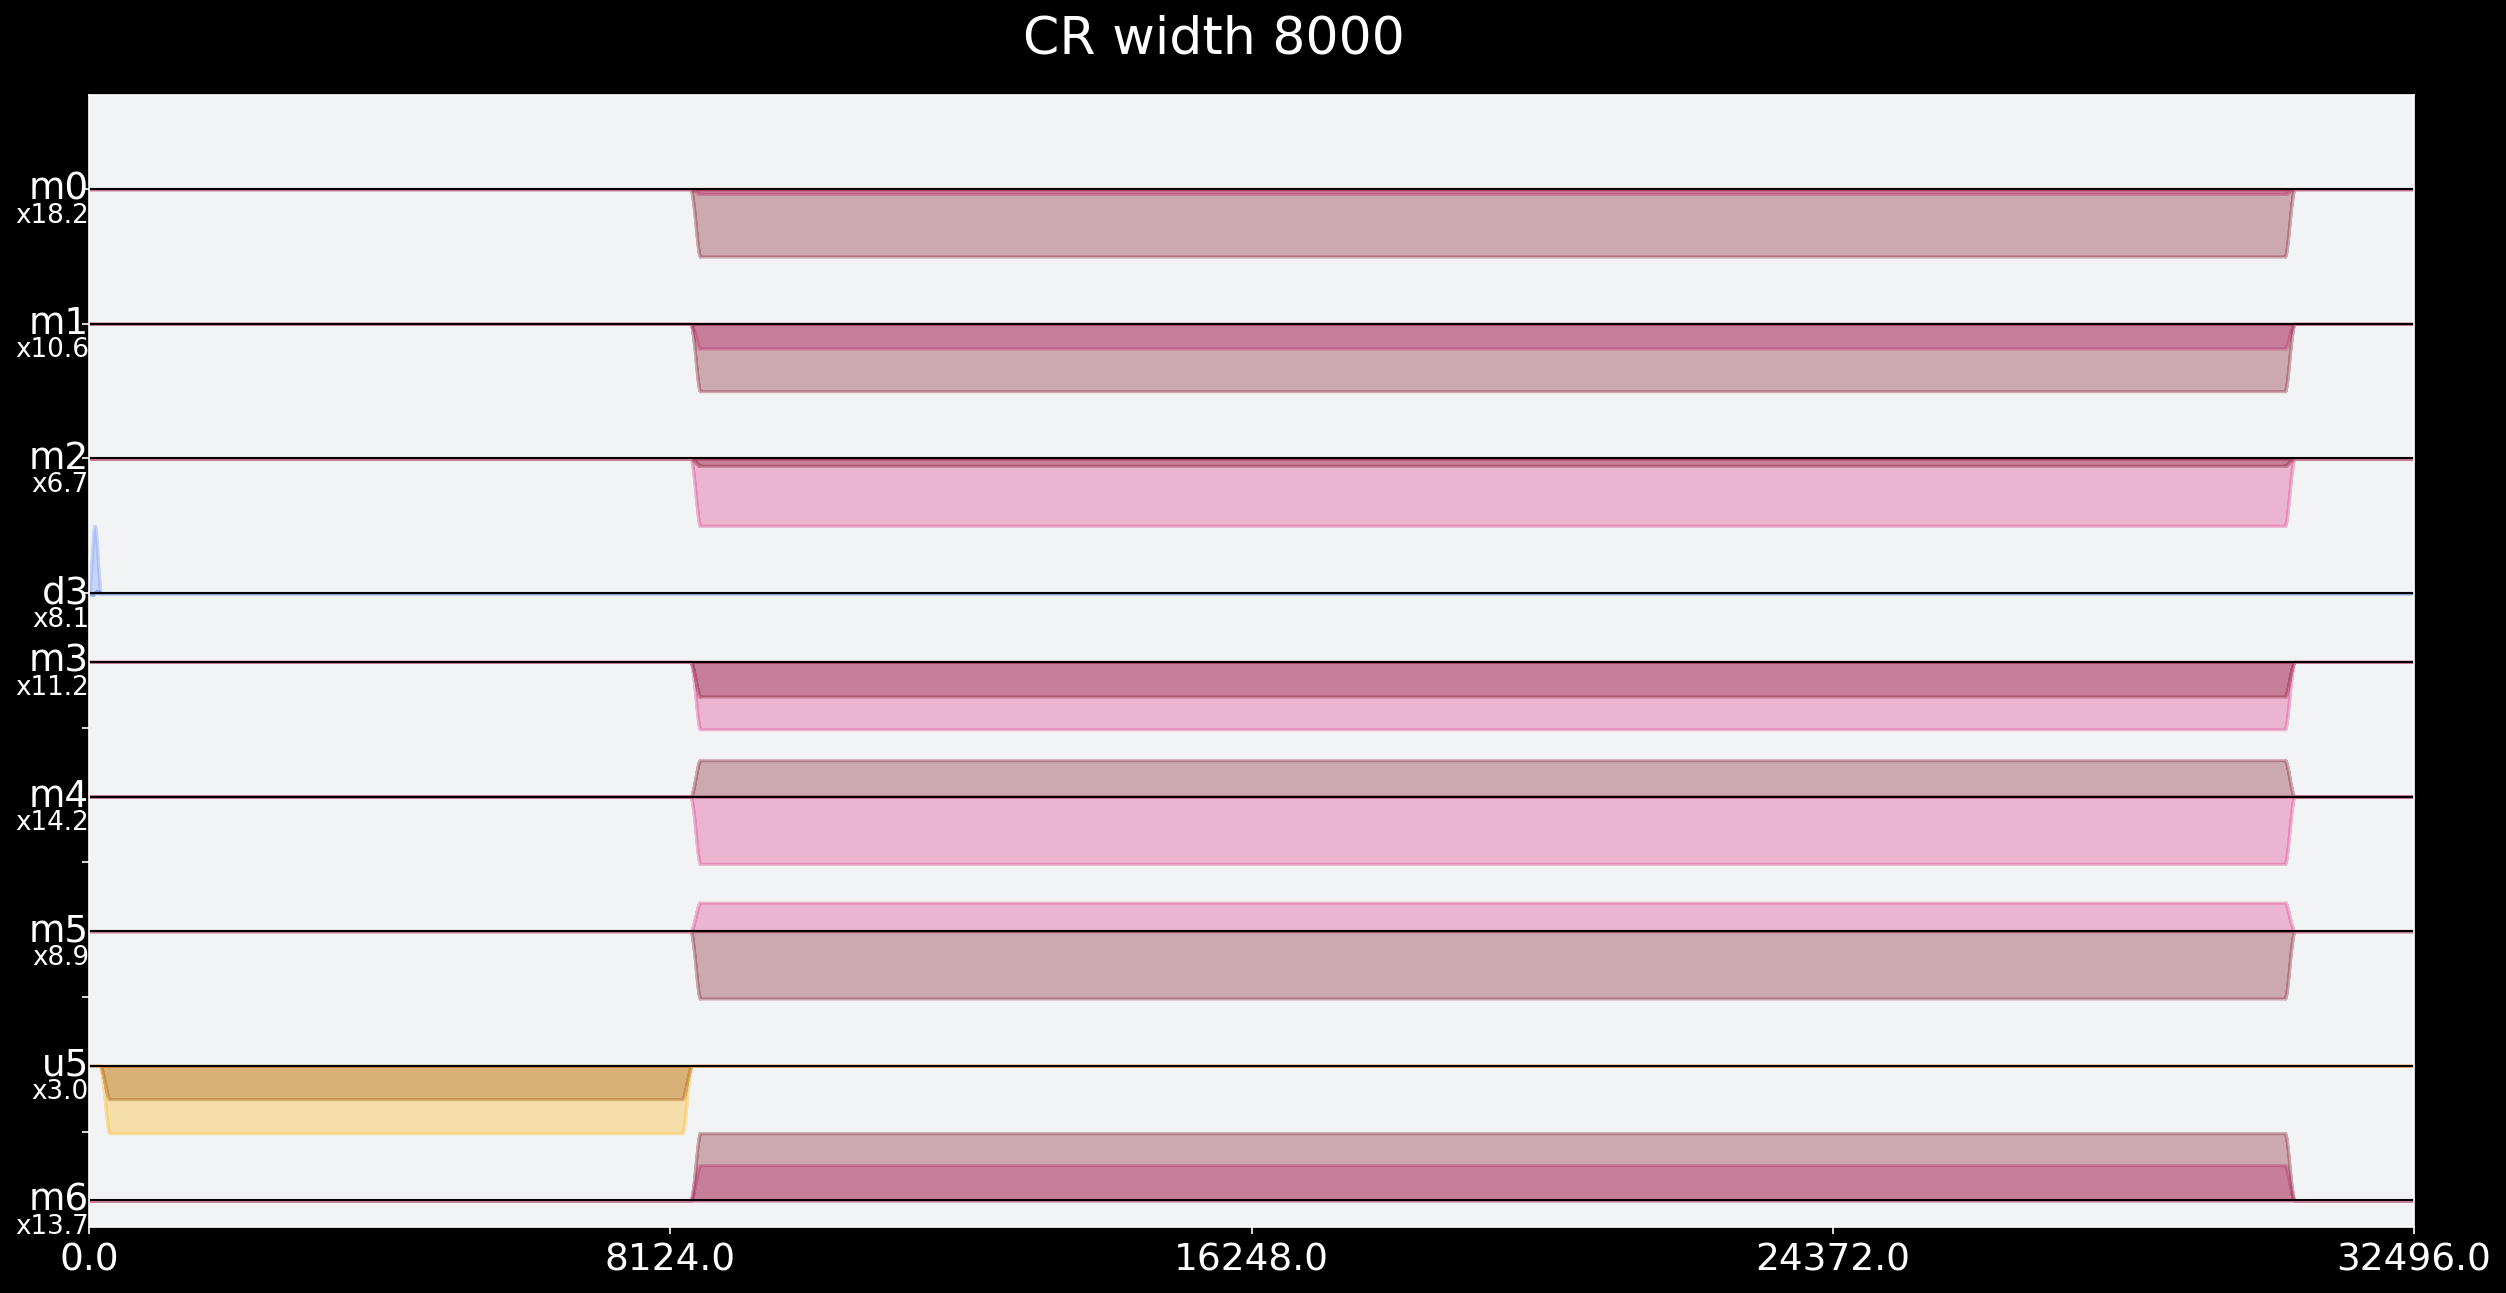

In [46]:
cr_amp = cr_pulse_c3t1.amp
qc, qt = 3,1
cr_times = 16*np.linspace(0, 500, 21)
cr_scheds = build_cr_scheds(qc, qt, cr_times)
cr_scheds[-1].exclude(channels=[pulse.AcquireChannel(i) for i in range(backend_config.n_qubits)]).draw(style=style)

In [47]:
from qiskit import pulse            # This is where we access all of our Pulse features!
from qiskit.pulse import Play, Acquire
import qiskit.pulse.library as pulse_lib
import numpy as np

control = 3
target = 1

Q1_GHz, Q3_GHz

qubit = 1   # drive Q1 with frequency of Q3

inst_sched_map = backend_defaults.instruction_schedule_map
measure = inst_sched_map.get('measure', qubits=backend_config.meas_map[0])   # Get the default measurement pulse sequence
qubit_drive_sigma = 100e-9           #the width of the qubit spectroscopy drive
resonator_drive_sigma=10e-9          #the width of the resonator drive
drive_duration=10*qubit_drive_sigma  #the resonator drive duration

qubit_drive = pulse_lib.gaussian(duration = get_closest_multiple_of_16(drive_duration//dt),
                             amp = .1,
                             sigma = get_closest_multiple_of_16(qubit_drive_sigma//dt),
                             name = 'qubit tone')

## CCR pulse

CCR pulse drives both qubits in the frequency of each other:

- Old CR pulse is only one diretional: Build a CR pulse going in the other direction

- Use reconstruction of CR pulse to make a CR pulse going in the direction control 1 -> target 3

In [48]:
print(cr_pulse_c3t1) # drive control 3 in frequency of target 1
print(cr_pulse_c1t3) # drive control 1 in frequency of target 3

# verify default CR pulses are actually ony one pulse:
cr_pulse_c1t3 == cr_pulse_c3t1

GaussianSquare(duration=560, amp=(-0.3284667505753208-0.1625741842209951j), sigma=64, width=304)
GaussianSquare(duration=560, amp=(-0.3284667505753208-0.1625741842209951j), sigma=64, width=304)


True

In [42]:
# calibrated qubit frequencies from backend:
GHz_Qubit_default = [4.822060197521334, 4.759820204469057, 4.907307270165438, 4.8789602684859785, 
                     4.870898459748081, 4.963898651967502, 5.177100088457835]

# frequencies of q1 and q3:
Q1_GHz, Q3_GHz = GHz_Qubit_default[1], GHz_Qubit_default[3]

print(Q1_GHz, Q3_GHz)

4.759820204469057 4.8789602684859785


In [43]:
print(backend_defaults)

<PulseDefaults(<InstructionScheduleMap(1Q instructions:
  q0: {'rz', 'u2', 'x', 'u3', 'sx', 'id', 'u1', 'measure'}
  q1: {'rz', 'u2', 'x', 'u3', 'sx', 'id', 'u1', 'measure'}
  q2: {'rz', 'u2', 'x', 'u3', 'sx', 'id', 'u1', 'measure'}
  q3: {'rz', 'u2', 'x', 'u3', 'sx', 'id', 'u1', 'measure'}
  q4: {'rz', 'u2', 'x', 'u3', 'sx', 'id', 'u1', 'measure'}
  q5: {'rz', 'u2', 'x', 'u3', 'sx', 'id', 'u1', 'measure'}
  q6: {'rz', 'u2', 'x', 'u3', 'sx', 'id', 'u1', 'measure'}
Multi qubit instructions:
  (0, 1): {'cx'}
  (1, 0): {'cx'}
  (1, 2): {'cx'}
  (1, 3): {'cx'}
  (2, 1): {'cx'}
  (3, 1): {'cx'}
  (3, 5): {'cx'}
  (4, 5): {'cx'}
  (5, 3): {'cx'}
  (5, 4): {'cx'}
  (5, 6): {'cx'}
  (6, 5): {'cx'}
  (0, 1, 2, 3, 4, 5, 6): {'measure'}
)>Qubit Frequencies [GHz]
[4.822050715386461, 4.7598015138869805, 4.90731017805797, 4.8789741504115, 4.870907860340592, 4.963903536348521, 5.177095994418259]
Measurement Frequencies [GHz]
[7.284054663, 7.385438514, 7.32318003, 7.230756417, 7.280310863, 7.146993373

### default CR for control 3 -> target 1 (cr_pulse_c3t1) calibrated for frequency of target (Q1_GHz)

In [49]:
Q1_GHz

4.759820204469057

In [50]:
cr_pulse_c3t1

GaussianSquare(duration=560, amp=(-0.3284667505753208-0.1625741842209951j), sigma=64, width=304)

#### reconstrct CR for frequency of Q3

In [51]:
Q3_GHz

4.8789602684859785